In [1]:
#Data set
import numpy as np
import matplotlib.pyplot as plt
import pickle
import pandas as pd

N = 100 # number of points per class
D = 2 # dimensionality
K = 3 # number of classes
X = np.zeros((N*K,D))
y = np.zeros(N*K, dtype='uint8')
for j in range(K):
  ix = range(N*j,N*(j+1))
  r = np.linspace(0.0,1,N) # radius
  t = np.linspace(j*4,(j+1)*4,N) + np.random.randn(N)*0.2 # theta
  X[ix] = np.c_[r*np.sin(t), r*np.cos(t)]
  y[ix] = j

pickle.dump(X,open('dataX.pickle','wb'))
pickle.dump(y,open('dataY.pickle','wb'))

In [2]:
#Partition
from sklearn.model_selection import train_test_split
data_X_train, data_X_test, data_Y_train, data_Y_test = train_test_split(X, y, test_size=0.20)
print (" Training Dataset X Shape : ",data_X_train.shape)
print (" Test Dataset X Shape : ",data_X_test.shape)
print (" Training Dataset Y Shape : ",data_Y_train.shape)
print (" Test Dataset Y Shape : ",data_Y_test.shape)

 Training Dataset X Shape :  (240, 2)
 Test Dataset X Shape :  (60, 2)
 Training Dataset Y Shape :  (240,)
 Test Dataset Y Shape :  (60,)


In [7]:
def ffnmo(X,y,step_size, reg, no_iter):
        
    # Start with an initial set of parameters randomly
    h1 = 100 # size of hidden layer1
    #h2 = 100 # size of hidden layer2
    np.random.seed(1234)
    W1 = 0.01 * np.random.randn(D,h1)
    b1 = np.zeros((1,h1))
    W2 = 0.01 * np.random.randn(D,h1)
    b2 = np.zeros((1,h1))
    W3 = 0.01 * np.random.randn(h1,K)
    b3 = np.zeros((1,K))

    num_examples = X.shape[0]

    # gradient descent loop
    for i in range(no_iter):

        # evaluate class scores, [N x K]
        #hidden_layer1 = np.maximum(0, np.dot(X, W1) + b1) # note, ReLU activation
        #hidden_layer2 = np.maximum(0, np.dot(X, W2) + b2) # note, ReLU activation
        hidden_layer = np.maximum(np.dot(X, W1) + b1, np.dot(X, W2) + b2) # note, ReLU activation
        scores = np.dot(hidden_layer, W3) + b3

        # compute the class probabilities
        exp_scores = np.exp(scores)
        probs = exp_scores / np.sum(exp_scores, axis=1, keepdims=True) # [N x K]

        # compute the loss: average cross-entropy loss and regularization
        corect_logprobs = -np.log(probs[range(num_examples),y])
        data_loss = np.sum(corect_logprobs)/num_examples
        reg_loss = 0.5*reg*np.sum(W1*W1) + 0.5*reg*np.sum(W2*W2) + 0.5*reg*np.sum(W3*W3)
        loss = data_loss + reg_loss
        #if i % 1000 == 0:
            #print "iteration %d: loss %f" % (i, loss)

        # compute the gradient on scores
        dscores = probs
        dscores[range(num_examples),y] -= 1
        dscores /= num_examples
        
        dW3 = np.dot(hidden_layer.T, dscores)
        db3 = np.sum(dscores, axis=0, keepdims=True)
        
        #dhidden[hidden_layer <= 0] = 0
        dhidden2 = np.where(np.dot(X, W2) + b2 >= np.dot(X, W1) + b1, np.dot(dscores, W3.T), 0)
        dhidden  = np.where(np.dot(X, W2) + b2 <= np.dot(X, W1) + b1, np.dot(dscores, W3.T), 0)
  
        # finally into W,b, W2,b2
  
        dW2 = np.dot(X.T, dhidden2)
        db2 = np.sum(dhidden2, axis=0, keepdims=True)
        dW1 = np.dot(X.T, dhidden)
        db1 = np.sum(dhidden, axis=0, keepdims=True)
        

        # add regularization gradient contribution
        dW3 += reg * W3
        dW2 += reg * W2
        dW1 += reg * W1

        # perform a parameter update
        W1 += -step_size * dW1
        b1 += -step_size * db1
        W2 += -step_size * dW2
        b2 += -step_size * db2
        W3 += -step_size * dW3
        b3 += -step_size * db3
    return(W1,b1,W2,b2,W3,b3)


In [9]:
#Question 5.3.3
#Evaluate the Train and Test Accuracy

W1,b1,W2,b2,W3,b3 = ffnmo(data_X_train,data_Y_train, 0.7,0.0005,1000)
hidden_layer = np.maximum(np.dot(data_X_train, W1) + b1, np.dot(data_X_train, W2) + b2) # note, ReLU activation
scores = np.dot(hidden_layer, W3) + b3
predicted_class = np.argmax(scores, axis=1)
print ('Train accuracy: %.2f' % (np.mean(predicted_class == data_Y_train)*100))


hidden_layer = np.maximum(np.dot(data_X_test, W1) + b1, np.dot(data_X_test, W2) + b2) # note, ReLU activation
scores = np.dot(hidden_layer, W3) + b3
predicted_class = np.argmax(scores, axis=1)
Test_Acc=(np.mean(predicted_class == data_Y_test)*100)
print ('Test accuracy: %.2f' % Test_Acc)

Train accuracy: 93.33
Test accuracy: 95.00


In [15]:
#Question 5.2.4
from sklearn import cross_validation
cv = cross_validation.KFold(len(X), n_folds=10,shuffle=True, random_state=None)
#print(cv)
#Define some local varaibles
D = X.shape[1] #Number of features
K = 3 #Number of classes assuming class index starts from 0

# Start with an initialize parameters randomly


# Initial values from hyperparameter
reg = 1e-3 # regularization strength


result=[]

for traincv,testcv in cv:
   
    X_train, X_test = X[traincv], X[testcv]
    y_train, y_test = y[traincv], y[testcv]
    W1,b1,W2,b2,W3,b3 = ffnmo(X_train,y_train, 0.7,0.0005,1000)
    hidden_layer = np.maximum(np.dot(X_test, W1) + b1, np.dot(X_test, W2) + b2) # note, ReLU activation
    scores = np.dot(hidden_layer, W3) + b3
    predicted_class = np.argmax(scores, axis=1)
    result.append(np.mean(predicted_class == y_test))
print ("Validation Accuracy: %.2f" % (np.array(result).mean()*100))
print ("Test Accuracy: %.2f" % Test_Acc) 


Validation Accuracy: 93.00
Test Accuracy: 95.00


20
50
100
200
500


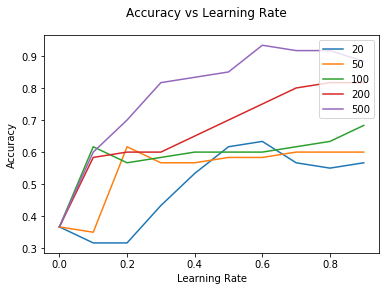

In [18]:
#Question 5.3.5
result=[]
W1=[]
b1=[]
W = 0.01 * np.random.randn(D,K)
b = np.zeros((1,K))
giter=[20,50,100,200,500]
for j in giter[:]:
    learning_rate=[]
    result=[]
    for i in range(10):
        learning_rate.append(0.1*i)
        W1,b1,W2,b2,W3,b3= ffnmo(data_X_train,data_Y_train,0.1*i,0.001,j)
        hidden_layer = np.maximum(np.dot(data_X_test, W1) + b1, np.dot(data_X_test, W2) + b2) # note, ReLU activation
        scores = np.dot(hidden_layer, W3) + b3
        predicted_class = np.argmax(scores, axis=1)
        result.append(np.mean(predicted_class == data_Y_test))    
    plt.plot(learning_rate,result)
    print(j)
plt.suptitle('Accuracy vs Learning Rate')
plt.xlabel('Learning Rate')
plt.ylabel('Accuracy')
plt.legend(['20', '50', '100', '200','500'], loc='upper right')
plt.show()

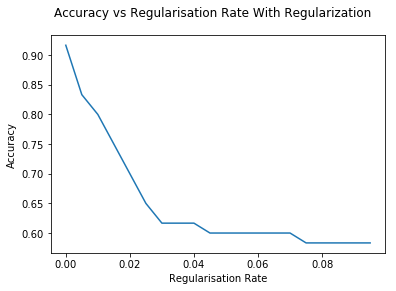

Best Accuracy with Regularization parameter  : 91.67 
Best Regularization parameter with Regularization parameter : 0.00000
Best Accuracy without Regularization parameter  : 91.67 


In [28]:
#Question 5.2.6
accuracy=[]
learning_rate=[]
regu_rate=[]
resultl=[]
W1=[]
b1=[]
resultr=[]
for j in range(20):
    regu_rate.append(0.005*j)
    W1,b1,W2,b2,W3,b3= ffnmo(data_X_train,data_Y_train,0.4,0.005*j,1000)
    hidden_layer = np.maximum(np.dot(data_X_test, W1) + b1, np.dot(data_X_test, W2) + b2)# note, ReLU activation
    scores = np.dot(hidden_layer, W3) + b3
    
    predicted_class = np.argmax(scores, axis=1)
    resultr.append(np.mean(predicted_class == data_Y_test))
plt.plot(regu_rate,resultr)
plt.suptitle('Accuracy vs Regularisation Rate With Regularization')
plt.xlabel('Regularisation Rate')
plt.ylabel('Accuracy')
plt.show()
max_acc=max(resultr)
index=resultr.index(max_acc)
print ("Best Accuracy with Regularization parameter  : %.2f " % (max_acc*100))
print ("Best Regularization parameter with Regularization parameter : %.5f" % regu_rate[index])
resultr1=[]
W1,b1,W2,b2,W3,b3= ffnmo(data_X_train,data_Y_train,0.4,0,1000)
hidden_layer = np.maximum(np.dot(data_X_test, W1) + b1, np.dot(data_X_test, W2) + b2) # note, ReLU activation
scores2 = np.dot(hidden_layer, W3) + b3
predicted_class2 = np.argmax(scores2, axis=1)
resultr1.append(np.mean(predicted_class2 == data_Y_test))


max_acc1=max(resultr1)
index1=resultr1.index(max_acc1)
print ("Best Accuracy without Regularization parameter  : %.2f " % (max_acc1*100))

In [27]:
#Question 5.2.7
data_X_train50, data_X_test50, data_Y_train50, data_Y_test50 = train_test_split(X, y, test_size=0.50)
W1,b1,W2,b2,W3,b3=ffnmo(data_X_train50,data_Y_train50,0.7,0.001,1000)
hidden_layer = np.maximum(np.dot(data_X_train, W1) + b1, np.dot(data_X_train, W2) + b2)# note, ReLU activation
scores = np.dot(hidden_layer, W3) + b3
predicted_class = np.argmax(scores, axis=1)
print ('train accuracy with 50:50 split: %.2f' % (np.mean(predicted_class == data_Y_train)*100))

hidden_layer = np.maximum(np.dot(data_X_test, W1) + b1, np.dot(data_X_test, W2) + b2)# note, ReLU activation
scores = np.dot(hidden_layer, W3) + b3
predicted_class = np.argmax(scores, axis=1)
Test_Acc=(np.mean(predicted_class == data_Y_test)*100)
print ('Test accuracy with 50:50 split: %.2f' % Test_Acc)

train accuracy with 50:50 split: 94.17
Test accuracy with 50:50 split: 96.67
